In [1]:
#importing libraries

import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
import sklearn
from sklearn.model_selection import cross_validate, GridSearchCV
import xgboost as xgb
from sklearn import ensemble
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


ModuleNotFoundError: No module named 'xgboost'

In [2]:
# Set custom style settings:

plt.rcParams['figure.figsize'] = (11, 7)
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['figure.titlesize'] = 'large'
plt.rcParams['lines.markersize'] = 6
sns.set_style('whitegrid')
sns.set_context("talk")

In [3]:
import os

In [4]:
os.getcwd()

'/Users/Youmei/Desktop/UTOKYO/M2 A1/machine learning and data science/ml project/submission'

In [5]:
os.chdir('/Users/Youmei/Desktop/ml project/data')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Youmei/Desktop/ml project/data'

# Data Cleaning

In [6]:
df_train = pd.read_csv('train_users.csv')
df_test = pd.read_csv('test_users.csv')
df_countries = pd.read_csv('countries.csv')
df_train.shape, df_test.shape, df_countries.shape

FileNotFoundError: [Errno 2] No such file or directory: 'train_users.csv'

In [7]:
# Store country names
Destination = df_train['country_destination'].values
df_train1 = df_train.drop(['country_destination'], axis=1)
# Combining the test and train data.
df_all =  pd.concat((df_train1, df_test), axis = 0, ignore_index = True)
print("The Dimensions of total set is ",df_all.shape)
df_all.head()

The Dimensions of total set is  (275547, 15)


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


In [8]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       275547 non-null  object 
 1   date_account_created     275547 non-null  object 
 2   timestamp_first_active   275547 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   275547 non-null  object 
 5   age                      158681 non-null  float64
 6   signup_method            275547 non-null  object 
 7   signup_flow              275547 non-null  int64  
 8   language                 275547 non-null  object 
 9   affiliate_channel        275547 non-null  object 
 10  affiliate_provider       275547 non-null  object 
 11  first_affiliate_tracked  269462 non-null  object 
 12  signup_app               275547 non-null  object 
 13  first_device_type        275547 non-null  object 
 14  firs

In [9]:
df_all.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         186639
gender                          0
age                        116866
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6085
signup_app                      0
first_device_type               0
first_browser                   0
dtype: int64

In [10]:
id_test = df_test['id']
N_train = df_train.shape[0]

# Dropping the unnecessary variables. "id" is already stored, "date_first_booking" is only given in train sets, so I dropped it.
df_all = df_all.drop(['id','date_first_booking'], axis = 1)

In [11]:
df_all.gender.value_counts()

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64

In [12]:
df_all.groupby('gender').age.agg(['min','max','mean','count'])

,min,max,mean,count
gender,,,,
-unknown-,1.0,2014.0,44.581328,22237
FEMALE,1.0,2014.0,49.645347,71907
MALE,1.0,2014.0,45.191540,64258
OTHER,17.0,2014.0,57.146953,279


In [14]:
#It's impossible for age to be 2014, here I assume that age ranges from 18 to 100, and treat all other values as null.
df_all.loc[df_all.age > 100, 'age'] = np.nan
df_all.loc[df_all.age < 18, 'age'] = np.nan

#Filling the missing values of age with the median.
df_all["age"]=df_all["age"].fillna( df_all["age"].median())

In [15]:
df_all.groupby('gender').age.agg(['min','max','mean','count'])

,min,max,mean,count
gender,,,,
-unknown-,18.0,100.0,33.577997,129480
FEMALE,18.0,100.0,35.502696,77524
MALE,18.0,100.0,36.061649,68209
OTHER,18.0,78.0,35.425150,334


In [18]:
df_all['date_account_created'] = pd.to_datetime(df_all['date_account_created'])
df_all['timestamp_first_active'] = pd.to_datetime(df_all['timestamp_first_active'], format='%Y%m%d%H%M%S')

# Seperating Years and Months
df_all['dac_month'] = df_all['date_account_created'].apply(lambda x:x.month)
df_all['dac_year'] = df_all['date_account_created'].apply(lambda x:x.year)
df_all['tfa_month'] = df_all['timestamp_first_active'].apply(lambda x:x.month)
df_all['tfa_year'] = df_all['timestamp_first_active'].apply(lambda x:x.year)


df_all.drop('date_account_created',1, inplace=True)
df_all.drop('timestamp_first_active',1, inplace=True)

In [161]:
#df_all.reset_index(inplace=True)

In [19]:
df_all.head()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_month,dac_year,tfa_month,tfa_year
0,-unknown-,33.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,6,2010,3,2009
1,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,5,2011,5,2009
2,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,9,2010,6,2009
3,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,12,2011,10,2009
4,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,9,2010,12,2009


In [20]:
print("The Dimensions of total set is ",df_all.shape)
df_all.describe()

The Dimensions of total set is  (275547, 15)


,age,signup_flow,dac_month,dac_year,tfa_month,tfa_year
count,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000
mean,34.736546,4.291965,6.457505,2013.243828,6.457446,2013.243341
std,8.895211,8.794313,2.985339,0.921206,2.985189,0.921756
min,18.000000,0.000000,1.000000,2010.000000,1.000000,2009.000000
25%,32.000000,0.000000,4.000000,2013.000000,4.000000,2013.000000
50%,33.000000,0.000000,7.000000,2014.000000,7.000000,2014.000000
75%,34.000000,1.000000,9.000000,2014.000000,9.000000,2014.000000
max,100.000000,25.000000,12.000000,2014.000000,12.000000,2014.000000


# Data Visualizations

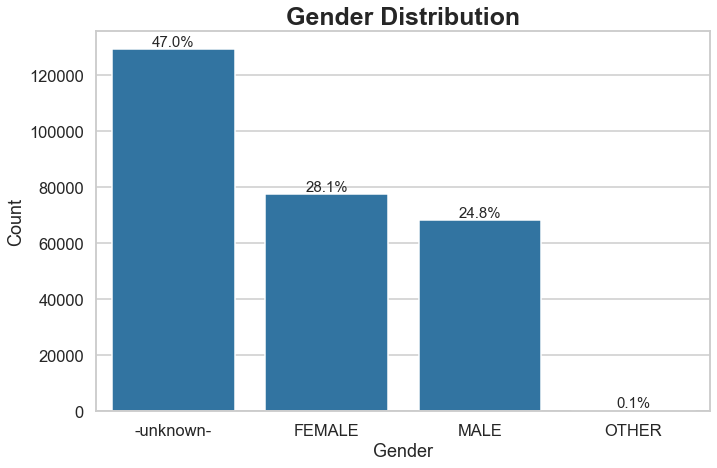

In [21]:
 #　Distribution for gender
order1 = df_all['gender'].value_counts().index
sns.countplot(data = df_all, x = 'gender', order = order1, color = sns.color_palette()[0])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution',fontsize=25,fontweight="bold")

order2 = df_all['gender'].value_counts()
for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_all.shape[0])
    plt.text(i,count+1000,strt,ha='center',fontsize=15)

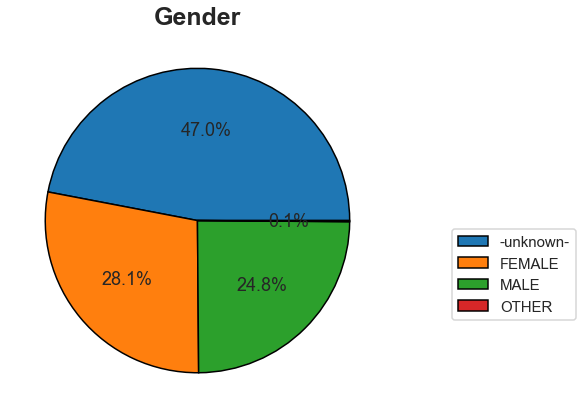

In [22]:
grp = df_all['gender'].value_counts()
labels=list(grp.index)
pie = plt.pie(grp.values, startangle=0, 
        autopct='%1.1f%%', wedgeprops={'edgecolor':'black'})
plt.title('Gender',fontsize=25,fontweight="bold")
plt.legend(pie[0],labels, bbox_to_anchor=(1,0.5), loc="best", fontsize=15, 
           bbox_transform=plt.gcf().transFigure)

plt.show()

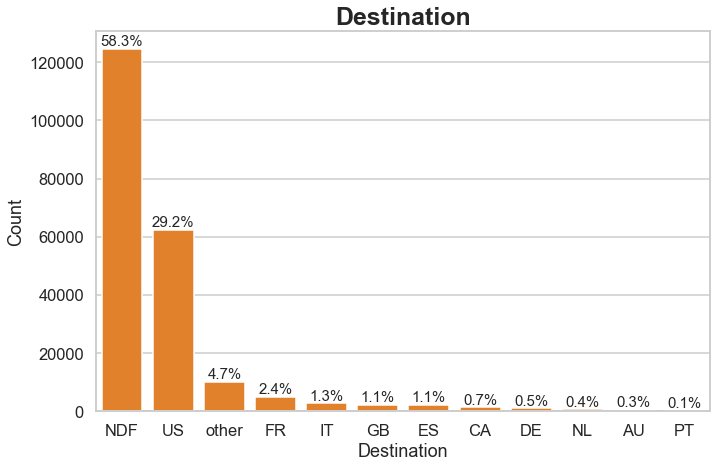

In [23]:
#Distribution for countries.
order1 = df_train['country_destination'].value_counts().index
sns.countplot(data = df_train, x = 'country_destination', order = order1, color = sns.color_palette()[1])
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Destination',fontsize=25,fontweight="bold")

order2 = df_train['country_destination'].value_counts()
for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_train.shape[0])
    plt.text(i,count+1000,strt,ha='center',fontsize=15)

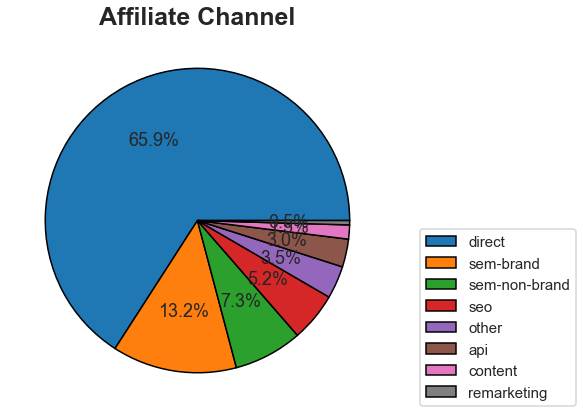

In [24]:
grp = df_all['affiliate_channel'].value_counts()
labels=list(grp.index)
pie = plt.pie(grp.values, startangle=0, 
        autopct='%1.1f%%', wedgeprops={'edgecolor':'black'})
plt.title('Affiliate Channel',fontsize=25,fontweight="bold")
plt.legend(pie[0],labels, bbox_to_anchor=(1,0.5), loc="best", fontsize=15, 
           bbox_transform=plt.gcf().transFigure)

plt.show()

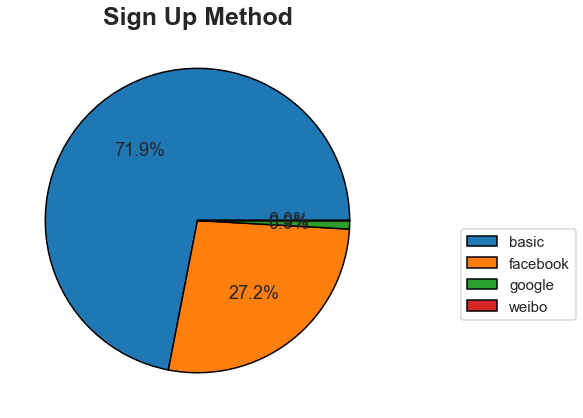

In [25]:
grp = df_all['signup_method'].value_counts()
labels=list(grp.index)
pie = plt.pie(grp.values, startangle=0, 
        autopct='%1.1f%%', wedgeprops={'edgecolor':'black'})
plt.title('Sign Up Method',fontsize=25,fontweight="bold")
plt.legend(pie[0],labels, bbox_to_anchor=(1,0.5), loc="best", fontsize=15, 
           bbox_transform=plt.gcf().transFigure)

plt.show()

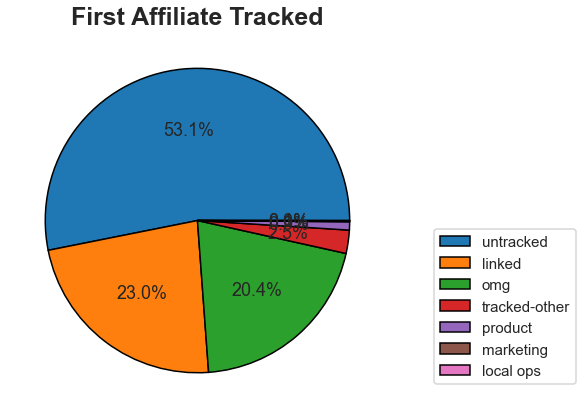

In [26]:
grp = df_all['first_affiliate_tracked'].value_counts()
labels=list(grp.index)
pie = plt.pie(grp.values, startangle=0, 
        autopct='%1.1f%%', wedgeprops={'edgecolor':'black'})
plt.title('First Affiliate Tracked',fontsize=25,fontweight="bold")
plt.legend(pie[0],labels, bbox_to_anchor=(1,0.5), loc="best", fontsize=15, 
           bbox_transform=plt.gcf().transFigure)

plt.show()


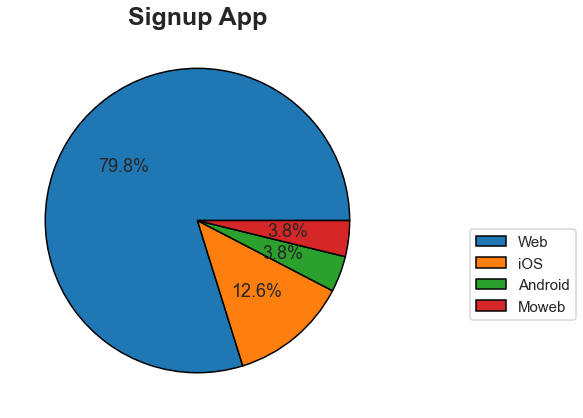

In [27]:
grp = df_all['signup_app'].value_counts()
labels=list(grp.index)
pie = plt.pie(grp.values, startangle=0, 
        autopct='%1.1f%%', wedgeprops={'edgecolor':'black'})
plt.title('Signup App',fontsize=25,fontweight="bold")
plt.legend(pie[0],labels, bbox_to_anchor=(1,0.5), loc="best", fontsize=15, 
           bbox_transform=plt.gcf().transFigure)

plt.show()

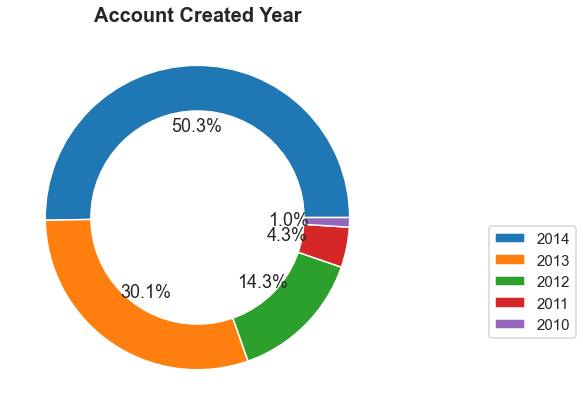

In [28]:
grp = df_all['dac_year'].value_counts()
labels=list(grp.index)
pie = plt.pie(grp.values, startangle=0, 
        autopct='%1.1f%%')
plt.title('Account Created Year',fontsize=20,fontweight="bold")
plt.legend(pie[0],labels, bbox_to_anchor=(1,0.5), loc="best", fontsize=15, 
           bbox_transform=plt.gcf().transFigure)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


plt.show()

In [29]:
df1 = df_all.groupby('dac_year').count()
df1.head()

years = [2010,2011,2012,2013,2014]
yearsOrder=pd.api.types.CategoricalDtype(ordered=True, categories=years)
df1.reset_index(inplace = True)
df1.dac_year = df1.dac_year.astype(yearsOrder)

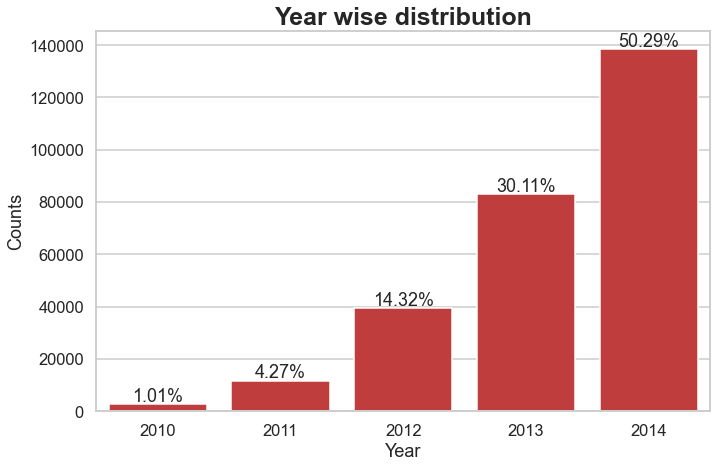

In [50]:
sns.barplot(data=df1,x='dac_year',y='affiliate_provider',color=sns.color_palette()[3]);
plt.title('Year wise distribution',fontsize=25,fontweight="bold");
plt.xlabel('Year')
plt.ylabel('Counts')
for i in range(df1.shape[0]):
    count=df1.iloc[i]['affiliate_provider']
    strt='{:0.2f}%'.format(100*count/df_all.shape[0])
    plt.text(i,count+1000,strt,ha='center')

In [31]:
df2 = df_all[df_all['dac_year']==2013]
df2 = df2.groupby('dac_month').count()

df3 = df_all[df_all['dac_year']==2014]
df3 = df3.groupby('dac_month').count()

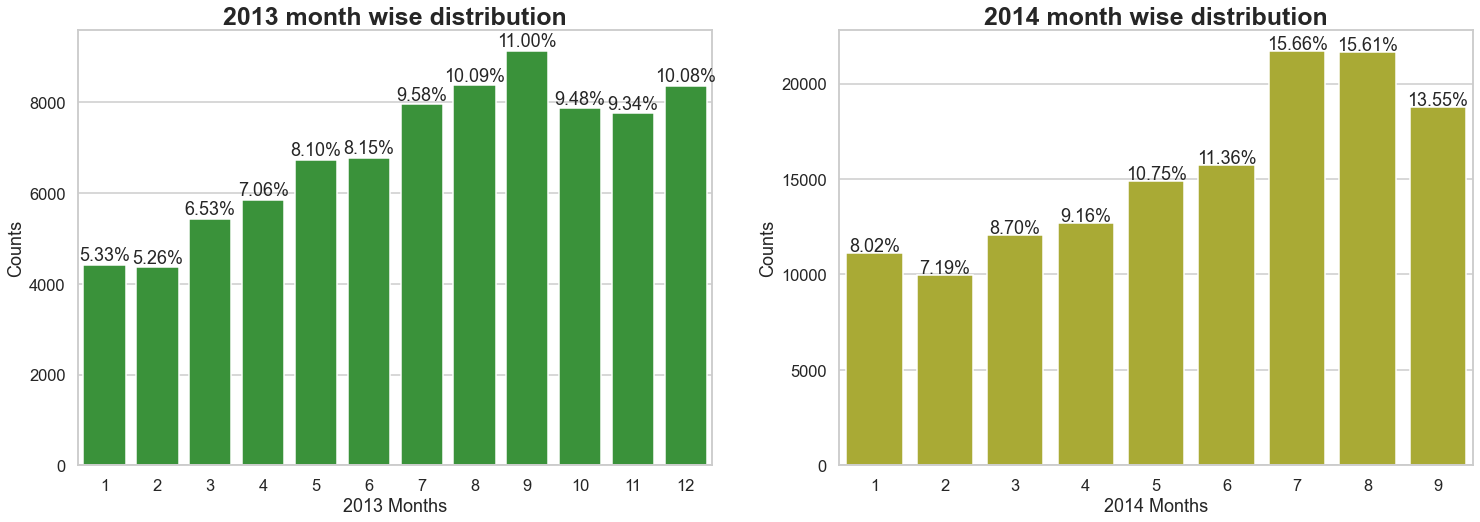

In [32]:
plt.figure(figsize=(25,8))

column_name = "affiliate_provider"
df2column_sum = df2[column_name].sum()
df3column_sum = df3[column_name].sum()
plt.subplot(1, 2, 1)
sns.barplot(data=df2,x=df2.index,y='affiliate_provider',color=sns.color_palette()[2]);
plt.title('2013 month wise distribution',fontsize=25,fontweight="bold");
plt.xlabel('2013 Months')
plt.ylabel('Counts')
for i in range(df2.shape[0]):
    count1=df2.iloc[i]['affiliate_provider']
    strt='{:0.2f}%'.format(100*count1/df2column_sum)
    plt.text(i,count1+100,strt,ha='center')

plt.subplot(1, 2, 2)
sns.barplot(data=df3,x=df3.index,y='affiliate_provider',color=sns.color_palette()[8]);
plt.title('2014 month wise distribution',fontsize=25,fontweight="bold");
plt.xlabel('2014 Months')
plt.ylabel('Counts')
for i in range(df3.shape[0]):
    count2=df3.iloc[i]['affiliate_provider']
    strt='{:0.2f}%'.format(100*count2/df3column_sum)
    plt.text(i,count2+100,strt,ha='center')

In [51]:
df_all.language.value_counts(sort=True)

en           265538
zh             2634
fr             1508
es             1174
ko             1116
de              977
it              633
ru              508
ja              345
pt              322
sv              176
nl              134
tr               92
pl               75
da               75
no               51
cs               49
el               30
th               28
hu               25
id               23
fi               20
ca                6
is                5
hr                2
-unknown-         1
Name: language, dtype: int64

In [52]:
df_all.language.describe()

count     275547
unique        26
top           en
freq      265538
Name: language, dtype: object

In [53]:
df_all.language.value_counts("en")

en           0.963676
zh           0.009559
fr           0.005473
es           0.004261
ko           0.004050
de           0.003546
it           0.002297
ru           0.001844
ja           0.001252
pt           0.001169
sv           0.000639
nl           0.000486
tr           0.000334
pl           0.000272
da           0.000272
no           0.000185
cs           0.000178
el           0.000109
th           0.000102
hu           0.000091
id           0.000083
fi           0.000073
ca           0.000022
is           0.000018
hr           0.000007
-unknown-    0.000004
Name: language, dtype: float64

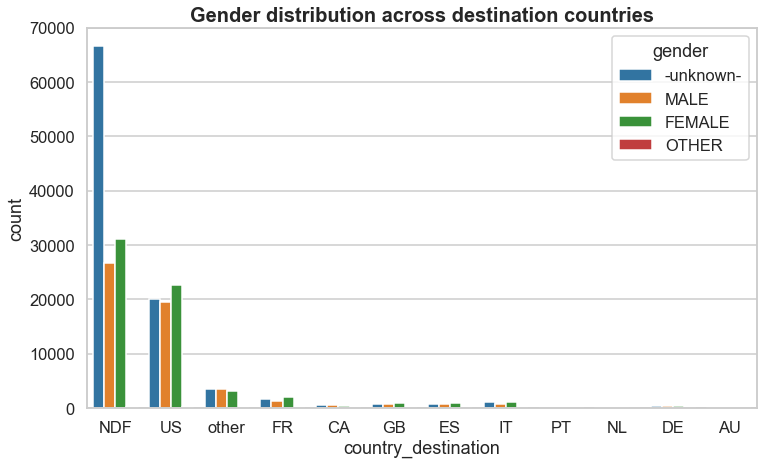

In [54]:
plt.figure(figsize=(12,7))
sns.countplot(x='country_destination', hue='gender', data=df_train)
plt.title('Gender distribution across destination countries',fontsize=20,fontweight="bold")
plt.show()

Text(0, 0.5, 'Counts')

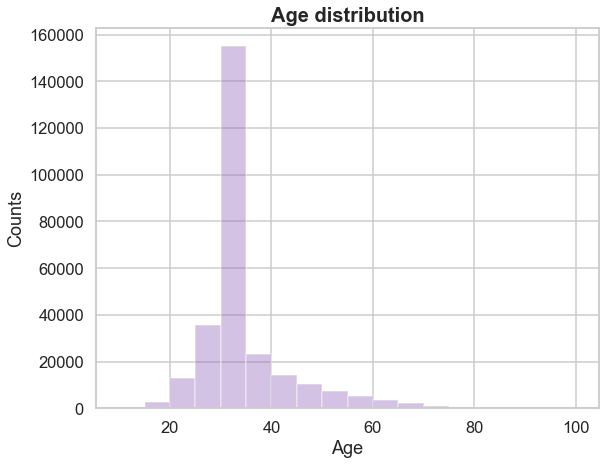

In [55]:
plt.figure(figsize=[9,7])
sns.distplot(df_all.age.dropna(),bins=np.arange(10,100+5,5),color=sns.color_palette()[4],kde=False);
plt.title('Age distribution',fontsize=20,fontweight="bold")
plt.xlabel('Age')
plt.ylabel('Counts')

Text(0, 0.5, 'Age')

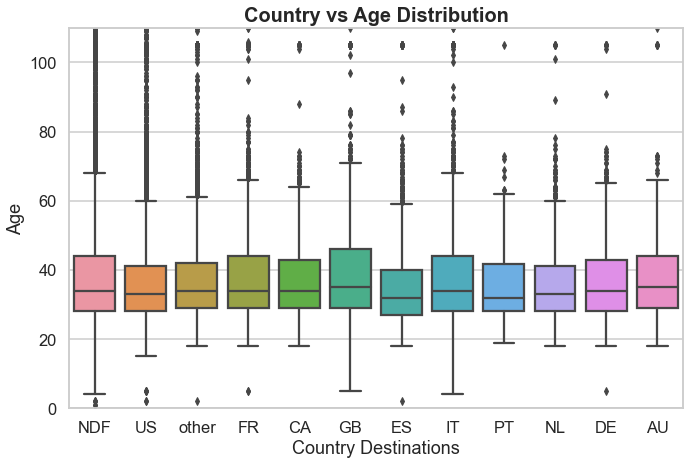

In [56]:
plt.figure(figsize=[11,7])
y = df_train.age
x = df_train.country_destination
fig = sns.boxplot(x,y,)
fig.axis(ymin=0, ymax=110)
plt.title('Country vs Age Distribution',fontsize=20,fontweight="bold")
plt.xlabel('Country Destinations')
plt.ylabel('Age')

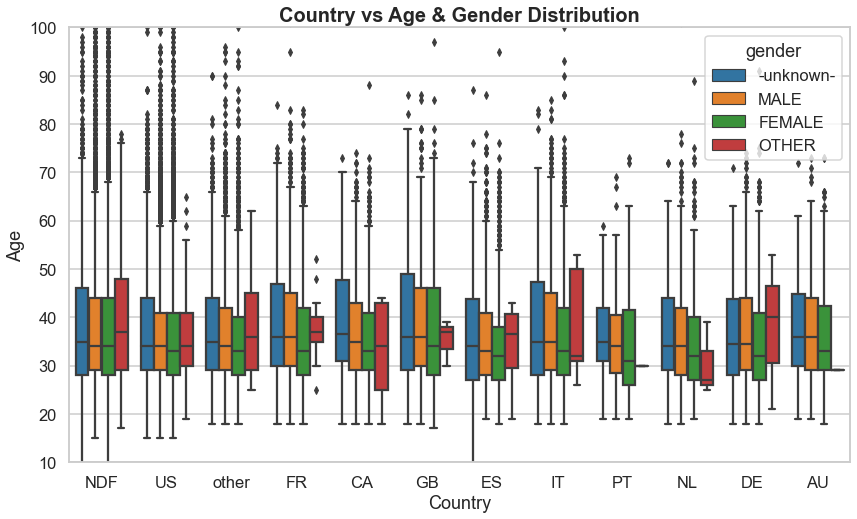

In [39]:
#Relation ship between age-gender-destination

plt.figure(figsize=[14,8])
sns.boxplot(data=df_train,y='age',x='country_destination',hue='gender');
plt.ylim(10,100)
plt.xlabel('Country');
plt.ylabel('Age');
plt.title('Country vs Age & Gender Distribution',fontsize=20,fontweight="bold");

In [40]:
signup_flow = DataFrame (df_all['signup_flow'].value_counts())
signup_flow

,signup_flow
0,206092
25,29834
12,11244
3,8822
2,6881
23,6408
24,4328
1,1047
8,315
6,301


In [41]:
df_all.groupby('signup_flow')[['age']].mean()

,age
signup_flow,
0,35.092032
1,37.234957
2,36.357216
3,35.617547
4,57.000000
5,43.388889
6,34.833887
8,33.079365
10,45.500000


In [43]:
affiliate = DataFrame (df_all['affiliate_provider'].value_counts())
affiliate

,affiliate_provider
direct,181270
google,65956
other,13036
facebook,3996
bing,3719
craigslist,3475
padmapper,836
vast,830
yahoo,653
facebook-open-graph,566


In [44]:
df_all.groupby('affiliate_provider')[['age']].mean()

,age
affiliate_provider,
baidu,30.187500
bing,38.090616
craigslist,35.846043
daum,38.000000
direct,34.274265
email-marketing,35.681481
facebook,33.650400
facebook-open-graph,37.683746
google,35.947435


In [45]:
first_browser = DataFrame (df_all['first_browser'].value_counts())
first_browser

,first_browser
Chrome,78671
Safari,53302
-unknown-,44394
Firefox,38665
Mobile Safari,29636
IE,24744
Chrome Mobile,3186
Android Browser,1577
AOL Explorer,254
Opera,228


In [46]:
firstdevicetype = DataFrame (df_all['first_device_type'].value_counts())
firstdevicetype

,first_device_type
Mac Desktop,106328
Windows Desktop,86948
iPhone,39814
iPad,18036
Other/Unknown,11167
Android Phone,9458
Android Tablet,2098
Desktop (Other),1507
SmartPhone (Other),191


In [47]:
df_all.groupby('first_device_type')[['age']].mean()

,age
first_device_type,
Android Phone,33.265912
Android Tablet,35.727836
Desktop (Other),33.885866
Mac Desktop,34.726225
Other/Unknown,34.129130
SmartPhone (Other),33.628272
Windows Desktop,35.520322
iPad,36.530938
iPhone,32.744587


# Preprocessing the dataset for building models

In [57]:
# Replacing unknowns with NaNs
df_all.gender.replace('-unknown-', np.nan, inplace=True)
df_all.first_browser.replace('-unknown-', np.nan, inplace=True)

In [58]:
df_all.isnull().sum()/df_all.isnull().count()*100

gender                     46.990169
age                         0.000000
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     2.208335
signup_app                  0.000000
first_device_type           0.000000
first_browser              16.111226
dac_month                   0.000000
dac_year                    0.000000
tfa_month                   0.000000
tfa_year                    0.000000
dtype: float64

In [59]:
# Create categorical columns
features = ['gender','signup_method', 'signup_flow', 'language', 'affiliate_channel',
               'affiliate_provider', 'first_affiliate_tracked','signup_app' ,'first_device_type', 'first_browser']
# get dummies
df_all2 = pd.get_dummies(df_all, columns=features)

In [60]:
df_all2.head()

,age,dac_month,dac_year,tfa_month,tfa_year,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,...,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,33.0,6,2010,3,2009,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,38.0,5,2011,5,2009,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,56.0,9,2010,6,2009,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,42.0,12,2011,10,2009,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,41.0,9,2010,12,2009,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
df_all2.describe()

,age,dac_month,dac_year,tfa_month,tfa_year,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,...,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
count,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,...,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000
mean,34.736546,6.457505,2013.243828,6.457446,2013.243341,0.281346,0.247540,0.001212,0.719376,0.271692,...,0.000624,0.000098,0.000007,0.000156,0.000004,0.000029,0.000007,0.000004,0.000051,0.000025
std,8.895211,2.985339,0.921206,2.985189,0.921756,0.449657,0.431584,0.034795,0.449305,0.444833,...,0.024976,0.009898,0.002694,0.012491,0.001905,0.005388,0.002694,0.001905,0.007128,0.005040
min,18.000000,1.000000,2010.000000,1.000000,2009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,4.000000,2013.000000,4.000000,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,7.000000,2014.000000,7.000000,2014.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,34.000000,9.000000,2014.000000,9.000000,2014.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,12.000000,2014.000000,12.000000,2014.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [65]:
df_all2.isnull().sum()

age                               0
dac_month                         0
dac_year                          0
tfa_month                         0
tfa_year                          0
                                 ..
first_browser_TenFourFox          0
first_browser_TheWorld Browser    0
first_browser_UC Browser          0
first_browser_Yandex.Browser      0
first_browser_wOSBrowser          0
Length: 156, dtype: int64

In [67]:
#Splitting train and test
V = df_all2.values
X_train = V[:N_train]
X_test = V[N_train:]

#Create labels
from sklearn.preprocessing import LabelEncoder
labler = LabelEncoder()
y = labler.fit_transform(Destination)

X_train1, X_validation, Y_train, Y_validation = train_test_split(X_train, y, test_size = 0.30, random_state = 1)


In [68]:
print(X_train1.shape)
print(X_validation.shape)
print(Y_train.shape)
print(Y_validation.shape)

(149415, 156)
(64036, 156)
(149415,)
(64036,)


# Model - Decision Tree Classifier

In [69]:
clf = DecisionTreeClassifier(max_depth=8)
model1 = clf.fit(X_train1, Y_train)
pred1= model1.predict(X_validation)
print (accuracy_score(Y_validation, pred1))

0.6318164782309951


# Model - Extreme Gradient Boosting

In [79]:
from xgboost.sklearn import XGBClassifier

# Implementation of the classifier (decision tree)
clf2 = XGBClassifier(max_depth=8, learning_rate=0.3, n_estimators=100)               
model2 = clf2.fit(X_train1, Y_train)
pred2 = model2.predict(X_validation) 
print (accuracy_score(Y_validation, pred2))

[23:07:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6342369916921732


# Model - Random Forest

In [80]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf3 = RandomForestClassifier(max_depth=8, n_estimators=100) 
model3 = clf3.fit(X_train1, Y_train)
pred3 = model3.predict(X_validation) 
print (accuracy_score(Y_validation, pred3))

0.5935411331126241


# Model - MLP classifier

In [74]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
model4 = mlp.fit(X_train1, Y_train)
pred4 = mlp.predict(X_validation)
print (accuracy_score(Y_validation, pred4))

0.6071897057904928


In [81]:
DT = accuracy_score(Y_validation, pred1)
GB = accuracy_score(Y_validation, pred2)
RF = accuracy_score(Y_validation, pred3)
NN = accuracy_score(Y_validation, pred4)
#Accuracy of each model
print("Accuracy Prediction for each model")
pd.DataFrame({'Decision Tree':DT, 'Gradient Boosting': GB, 'Random Forest':RF,'Neural Network':NN},index=[0])

Accuracy Prediction for each model


,Decision Tree,Gradient Boosting,Random Forest,Neural Network
0,0.631816,0.634237,0.593541,0.60719


# Fitting the test dataset into the Gradient Boosting Model

In [83]:
pred_prob = clf2.predict_proba(X_test)

#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += labler.inverse_transform(np.argsort(pred_prob[i])[::-1])[:5].tolist()


In [84]:
#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('submission.csv',index=False)

In [86]:
sub.head(5)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,ES
